# Calculating risk indices using CMIP6 data: a collection of recipes
This notebook tries to put together some code and scripts that I used in the last year to analyse CMIP6 data. It contains a few "recipes", stitched together to show a simplified workflow calculating the precipitation difference on a region between future and historical model outputs. 

Given that this is a simplified workflow, I will use the following assumptions:
- Using ERA5 as observations
- Q99 of January to March months as index
- Using SSP5-585 as future scenario (period 2041-2060)
- Linear interpolation: it is probably not the best choice for precipitation but I didn't want to complicate the workflow using additional libraries ([xesfm](https://xesmf.readthedocs.io/en/latest/) for example)

This notebook presents different "recipes" to estimate the increase of a specific event (extreme precipitation) in a future climate:

1. The average: we combine all the knowledge we have (CMIP6 ensemble)
2. Only the "best": we assume that "all models are equal, but some are more equal than others", thus we use only some of them (the best estimating the observed distribution)
3. Large models: we focus on the models with multiple members in the CMIP6 repositories, combining them to obtain a longer distribution with a better representation of extremes

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import seaborn as sns
import os, cdsapi, warnings
import scipy.stats

I am using a custom code containing a class that I use to streamline the data retrieval and the alignment with observations.

In [2]:
from c6data import model_tp

# Preparation

## Download ERA5
This function can be used to download [ERA5 data from CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) Follow the instructions in [this page](https://cds.climate.copernicus.eu/api-how-to) to set up the API.

In [3]:
def download_era5(filename:str, 
                  lat_min:int = -15, 
                 lat_max:int = -8,
                 lon_min:int = (298-360),
                 lon_max:int = (305-360)):
    c = cdsapi.Client()

    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'total_precipitation',
            'year': [
                '1980', '1981', '1982',
                '1983', '1984', '1985',
                '1986', '1987', '1988',
                '1989', '1990', '1991',
                '1992', '1993', '1994',
                '1995', '1996', '1997',
                '1998', '1999', '2000',
                '2001', '2002', '2003',
                '2004', '2005', '2006',
                '2007', '2008', '2009',
                '2010', '2011', '2012',
                '2013', '2014',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'time': '00:00',
            'area': [
                lat_max, lon_min, lat_min,
                lon_max,
            ],
            'format': 'grib',
        },
        filename)

## Selecting a region

Select a box containing a region in South America including the [AR6 SAM region](https://www.ipcc.ch/report/ar6/wg1/downloads/factsheets/IPCC_AR6_WGI_Regional_Fact_Sheet_Introduction.pdf) (South American Monsoon)

In [4]:
lat_min = -20
lat_max = -8
lon_min = 360-72
lon_max = 360-50

## Accessing CMIP6
The CMIP6 data is accessed using file list of the Zarr data stores provided by Google Cloud for Pangeo: https://pangeo-data.github.io/pangeo-cmip6-cloud/overview.html

In [5]:
list_cmip6_sims = pd.read_csv("https://storage.googleapis.com/cmip6/pangeo-cmip6.csv")

The list contains more than 500k different simulations

In [6]:
list_cmip6_sims.shape

(514818, 11)

In [7]:
list_cmip6_sims.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


For this analysis, I wlll select two groups of simulations: one for the historical period and one for the future projections based on SSP585. I will filter the rows in `list_cmip_sims` using the following variables:
1.  `experiment_id` defining the type of experiment
2.  `table_id` to selection atmospheric variables at monthly frequency
3.  `variable_id` to select precipitation `pr`
4.  `member_id` to select only the first member (realisation, `r` - the other letters are for initialisation, physics and forcing)

Useful resources (https://help.ceda.ac.uk/article/4801-cmip6-data) (https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit#heading=h.sqoyqmabpjai)

# 1. The Average
Probably the simplest approach: we load all the models and we average them. 

Let's select all the simulations for the historical period, using only the first realisation (member). 

In [8]:
lhis = (
    list_cmip6_sims
    .query("experiment_id == 'historical'")
    .query("table_id == 'Amon'")
    .query("variable_id == 'pr'")
    .query("member_id.str.contains('r1i1p1f1')")
    )

Considering our filteirng, we obtain more than 50 simulations for the precipitation for the historical period.

In [9]:
lhis.shape

(54, 11)

In [10]:
lhis.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
6257,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
28955,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32380,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43176,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
44435,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212


We can do the same for SSP585.

In [11]:
l585 = (
    list_cmip6_sims
    .query("experiment_id == 'ssp585'")
    .query("table_id == 'Amon'")
    .query("variable_id == 'pr'")
    .query("member_id.str.contains('r1i1p1f1')")
    )

For the scenario SSP585 there are fewer simulations

In [12]:
l585.shape

(34, 11)

In [13]:
l585.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2465,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
18981,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
64323,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314
95199,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
201410,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529


Select only the models that are present in both the sets (historical and ssp585)

In [14]:
selected_sims = pd.merge(lhis, l585, on = ['institution_id', 'source_id'], how = 'inner')
selected_sims.head()

,activity_id_x,institution_id,source_id,experiment_id_x,member_id_x,table_id_x,variable_id_x,grid_label_x,zstore_x,dcpp_init_year_x,version_x,activity_id_y,experiment_id_y,member_id_y,table_id_y,variable_id_y,grid_label_y,zstore_y,dcpp_init_year_y,version_y
0,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701,ScenarioMIP,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803,ScenarioMIP,ssp585,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190903
2,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126,ScenarioMIP,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314
3,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212,ScenarioMIP,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp5...,NaN,20190627
4,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222,ScenarioMIP,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...,NaN,20191108


Loading observations (ERA5) and doing some post-processing (renaming coordinates and converting to precipitation flux) 

In [15]:
obs_filename = f'ERA5_tp_{lat_min}-{lat_max}-{lon_min}-{lon_max}.grib'
if not os.path.exists(obs_filename):
    download_era5(obs_filename, lat_min, lat_max, lon_min-360, lon_max-360)

obs = xr.open_dataset(obs_filename)
obs = (
    obs
    .rename({'longitude': 'lon', 'latitude': 'lat'})
)
obs.coords['lon'] = obs.coords['lon'] + 360
obs['tp'] = obs['tp'] / 86.4 # from m to flux
obs['time'] = obs.time.values.astype('datetime64[M]')

C:\Users\matte\AppData\Local\Temp\ipykernel_1588\814781132.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  obs['time'] = obs.time.values.astype('datetime64[M]')
C:\Users\matte\AppData\Local\Temp\ipykernel_1588\814781132.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable 

### Doing the calculations
Now, we iterate through all the simulations carrying out the following steps.
1. The data is loaded from Pangeo public data for the two experiments on the specified domain
2. Observations are added to the class

All the simulations are added to the list `data_layers`

In [16]:
# Silencing a warning about the use of non-nanosecond np.datetime64 in xarray
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
# %%
data_layers = []
for _,row in selected_sims.iterrows():

    target_inst = row['institution_id']
    target_sour = row['source_id']
    
    mdata = model_tp.model_tp(
        this_institution_id= target_inst,
        this_source_id=target_sour,
        lat_min = lat_min, 
        lat_max = lat_max,
        lon_min = lon_min,
        lon_max = lon_max
    )
    
    mdata.add_observations(obs)
    
    data_layers.append(mdata)

Creating multi-model concatenating the simulations (that have the same resolution of the observations) and calculating the ensemble mean after selecting the specific months

In [18]:
his_mm = xr.concat([x.his for x in data_layers], dim = 'model')
fut_mm = xr.concat([x.fut for x in data_layers], dim = 'model')

his_mm = his_mm.sel(time=his_mm.time.dt.month.isin([1, 2, 3]))
fut_mm = fut_mm.sel(time=fut_mm.time.dt.month.isin([1, 2, 3]))

his_ensemble = his_mm.mean(dim = 'model')*86400
fut_ensemble = fut_mm.mean(dim = 'model')*86400

Selecting January to February also for the observations

In [19]:
obs = obs.sel(time=obs.time.dt.month.isin([1, 2, 3]))

### Compare mean fields

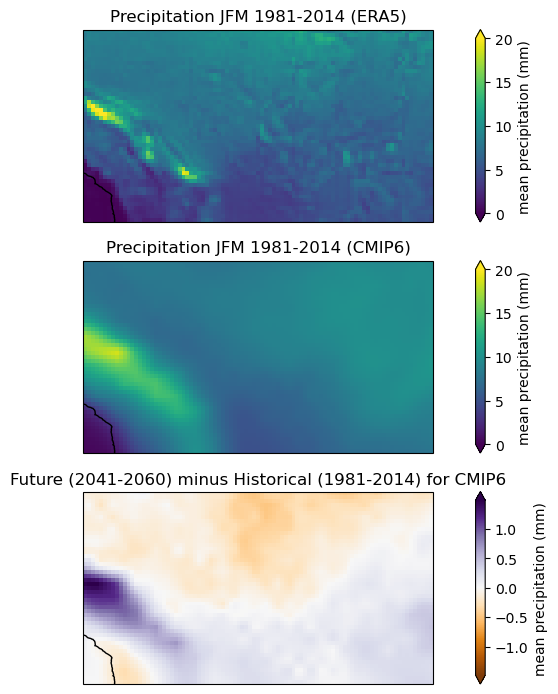

In [20]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).mean(dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 20, vmin = 0,
    cbar_kwargs={'label': "mean precipitation (mm)"}
)

axs[0].set_title('Precipitation JFM 1981-2014 (ERA5)')
axs[0].coastlines()

(his_ensemble['pr']).mean(dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 20, vmin = 0,
    cbar_kwargs={'label': "mean precipitation (mm)"}
)
axs[1].set_title('Precipitation JFM 1981-2014 (CMIP6)')
axs[1].coastlines()

((fut_ensemble['pr']).mean(dim = 'time') - (his_ensemble['pr']).mean(dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "mean precipitation (mm)"}
)
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014) for CMIP6')
axs[2].coastlines()


### Checking the agreement

The multi-model ensemble has 32 models, let's check their agreement on the direction of change (i.e., how many project a positive/negative change)

In [21]:
n_models =  len(data_layers)
delta_mm = fut_mm.mean(dim = 'time') - his_mm.mean(dim = 'time')
delta_mm['sign'] = np.sign(delta_mm['pr'])
delta_mm['agreement'] = np.abs(delta_mm['sign'].sum(dim = 'model'))
delta_mm['n_models_agree'] = delta_mm['agreement'] + (n_models - delta_mm['agreement'])/2

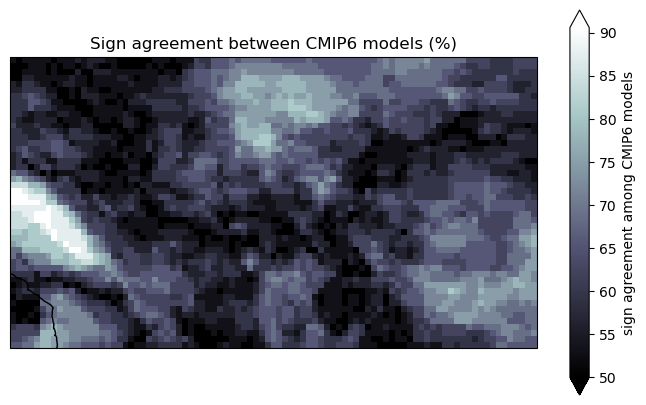

In [22]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,5))
(100*delta_mm['n_models_agree']/n_models).plot(
    ax = ax, transform = ccrs.PlateCarree(),
    cmap='bone',extend='both', 
    cbar_kwargs={'label': "sign agreement among CMIP6 models"}
)
ax.set_title('Sign agreement between CMIP6 models (%)')
ax.coastlines()


We can decide now to show the difference only for the grid points where there is an agreement bigger than 75% (just an example)

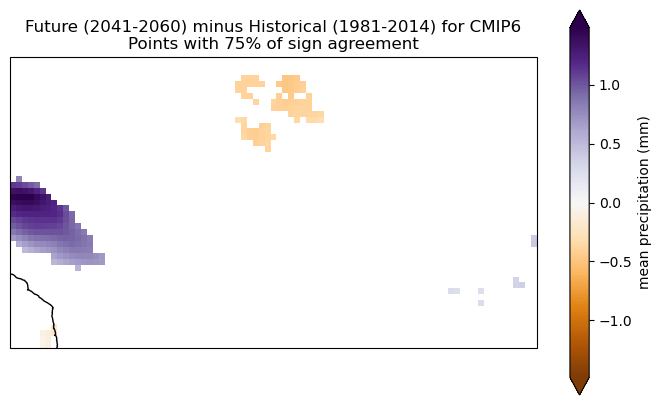

In [23]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,5))
(
    ((fut_ensemble['pr']).mean(dim = 'time') - (his_ensemble['pr'])
    .mean(dim = 'time'))
    .where((delta_mm['n_models_agree']/n_models) > .75)
    .plot(
        ax = ax, transform = ccrs.PlateCarree(),cmap='PuOr',extend='both',
        cbar_kwargs={'label': "mean precipitation (mm)"}
    )
)
ax.set_title('Future (2041-2060) minus Historical (1981-2014) for CMIP6\nPoints with 75% of sign agreement')
ax.coastlines()

### Calculating the 99th percentile

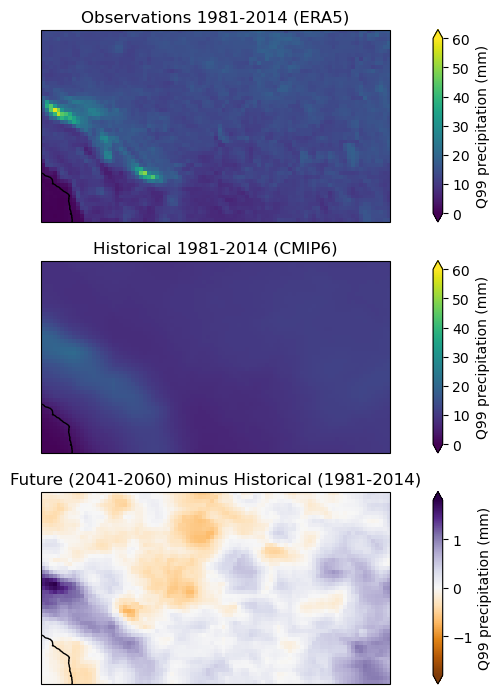

In [24]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
    )
axs[0].set_title('Observations 1981-2014 (ERA5)')
axs[0].coastlines()

(his_ensemble['pr']).quantile(.99, dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[1].set_title('Historical 1981-2014 (CMIP6)')
axs[1].coastlines()

((fut_ensemble['pr']).quantile(.99, dim = 'time') - (his_ensemble['pr']).quantile(.99, dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014)')
axs[2].coastlines()


### Comparing distributions
We can compare the distributions of all the grid points (for all the timesteps) showing the empirical distribution function.

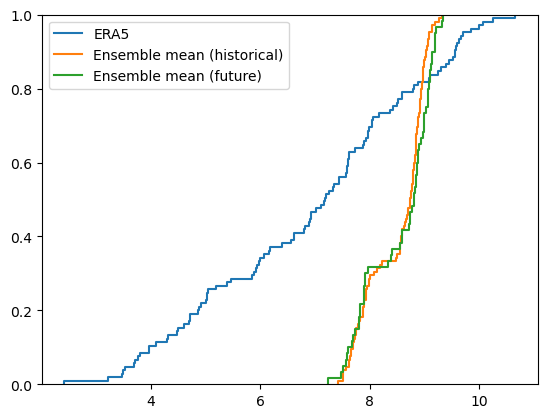

In [25]:
plt.ecdf(obs.mean(dim = ['lat', 'lon']).tp*86400, label = 'ERA5')
plt.ecdf(his_ensemble.mean(dim = ['lat', 'lon']).pr, label = 'Ensemble mean (historical)')
plt.ecdf(fut_ensemble.mean(dim = ['lat', 'lon']).pr, label = 'Ensemble mean (future)')
plt.legend()

It is evident the difference between the distribution of the observations (ERA5) and the CMIP6 model ensemble. This can be partially explained by the averaging applied to generate the ensemble mean. 

In the next plot we show the ECDF for all the single models being part of the multi-model (only for historical) where we see that actually the single models show a wider distribution comparable or larger in many cases than observations./

Text(0.5, 1.0, 'ECDF of observations (ERA5 in black) versus single CMIP6 models')

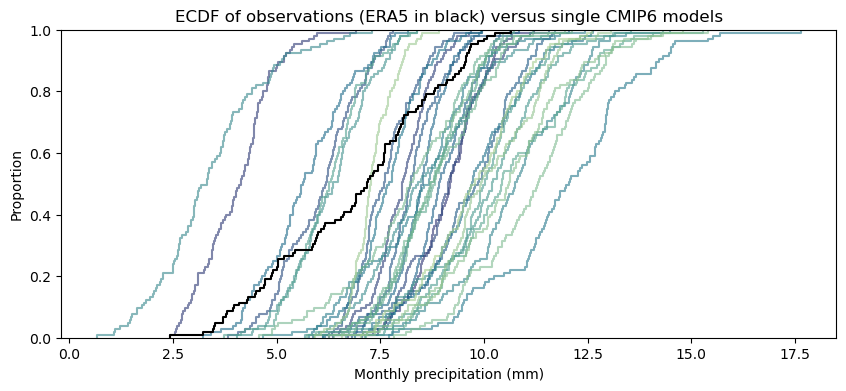

In [26]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.ecdfplot(data=(his_mm.pr*86400).mean(dim = ['lat', 'lon']).to_dataframe(), x='pr', hue='model', ax=ax, alpha = 0.6, palette = "crest")
sns.ecdfplot(data = (obs.tp*86400).mean(dim = ['lat', 'lon']).to_dataframe(), x = 'tp', ax = ax, color = 'black')
ax.get_legend().set_visible(False)
ax.set_xlabel( "Monthly precipitation (mm)") 
plt.title("ECDF of observations (ERA5 in black) versus single CMIP6 models")


### Applying the bias-correction to the models
The CMIP6 models will be bias corrected using [linear scaling](https://ibicus.readthedocs.io/en/latest/reference/debias.html#ibicus.debias.LinearScaling). Although there are several methods to bias correct a model, the linear scaling is chosen to preserve climate change signal.


In [27]:
bc_data_layers = []
for _,row in selected_sims.iterrows():

    target_inst = row['institution_id']
    target_sour = row['source_id']
    
    mdata = model_tp.model_tp(
        this_institution_id= target_inst,
        this_source_id=target_sour,
        lat_min = lat_min, 
        lat_max = lat_max,
        lon_min = lon_min,
        lon_max = lon_max
    )
    
    mdata.add_observations(obs)
    
    mdata.apply_bias_correction()
    
    bc_data_layers.append(mdata)

Again we create a multi-model concatenating the simulations and calculating the ensemble mean after selecting the specific months. 

In [28]:
his_mm_bc = xr.concat([x.his for x in bc_data_layers], dim = 'model')
fut_mm_bc = xr.concat([x.fut for x in bc_data_layers], dim = 'model')

his_mm_bc = his_mm_bc.sel(time=his_mm_bc.time.dt.month.isin([1, 2, 3]))
fut_mm_bc = fut_mm_bc.sel(time=fut_mm_bc.time.dt.month.isin([1, 2, 3]))

his_ensemble_bc = his_mm_bc.mean(dim = 'model')*86400
fut_ensemble_bc = fut_mm_bc.mean(dim = 'model')*86400


### Compare mean (with bias correction)

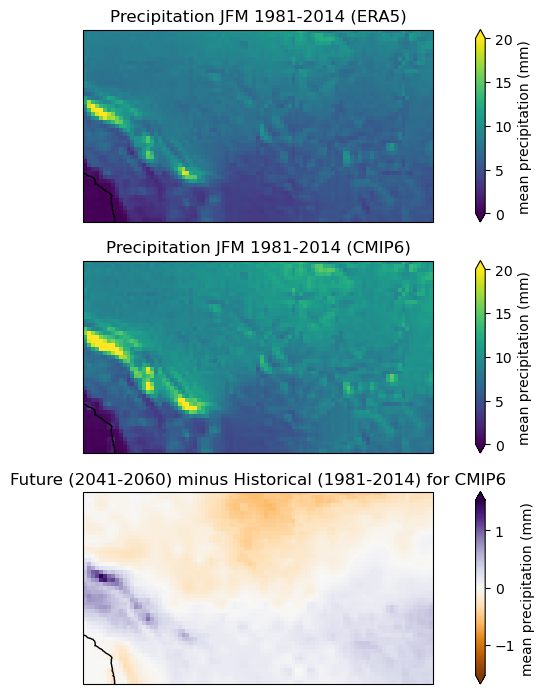

In [29]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).mean(dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 20, vmin = 0,
    cbar_kwargs={'label': "mean precipitation (mm)"}
)

axs[0].set_title('Precipitation JFM 1981-2014 (ERA5)')
axs[0].coastlines()

(his_ensemble_bc['pr']).mean(dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 20, vmin = 0,
    cbar_kwargs={'label': "mean precipitation (mm)"}
)
axs[1].set_title('Precipitation JFM 1981-2014 (CMIP6)')
axs[1].coastlines()

((fut_ensemble_bc['pr']).mean(dim = 'time') - (his_ensemble_bc['pr']).mean(dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "mean precipitation (mm)"}
)
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014) for CMIP6')
axs[2].coastlines()



### Compare 99th percentile (with bias correction)

Let's see now something different from the mean, we will focus on the 99th percentile, to see extreme values across the entire period. 

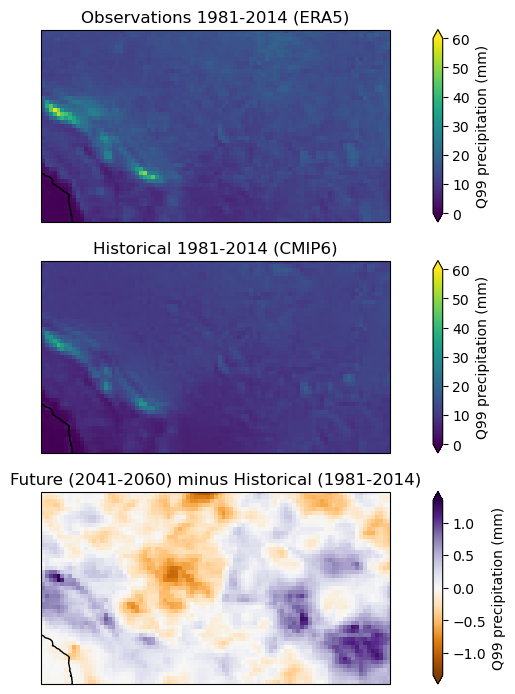

In [30]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
    )
axs[0].set_title('Observations 1981-2014 (ERA5)')
axs[0].coastlines()

(his_ensemble_bc['pr']).quantile(.99, dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[1].set_title('Historical 1981-2014 (CMIP6)')
axs[1].coastlines()

((fut_ensemble_bc['pr']).quantile(.99, dim = 'time') - (his_ensemble_bc['pr']).quantile(.99, dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014)')
axs[2].coastlines()


### Comparing distributions

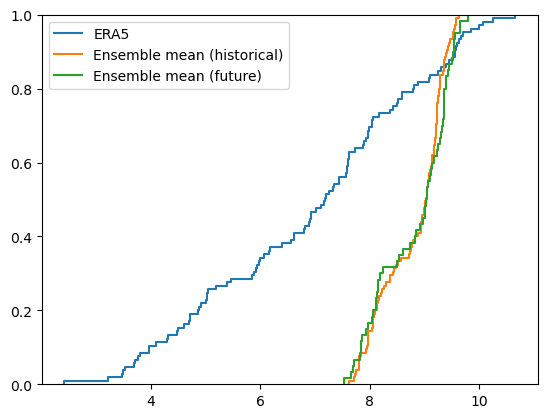

In [31]:
plt.ecdf(obs.mean(dim = ['lat', 'lon']).tp*86400, label = 'ERA5')
plt.ecdf(his_ensemble_bc.mean(dim = ['lat', 'lon']).pr, label = 'Ensemble mean (historical)')
plt.ecdf(fut_ensemble_bc.mean(dim = ['lat', 'lon']).pr, label = 'Ensemble mean (future)')
plt.legend()

Text(0.5, 1.0, 'ECDF of observations (ERA5 in black) versus single CMIP6 models')

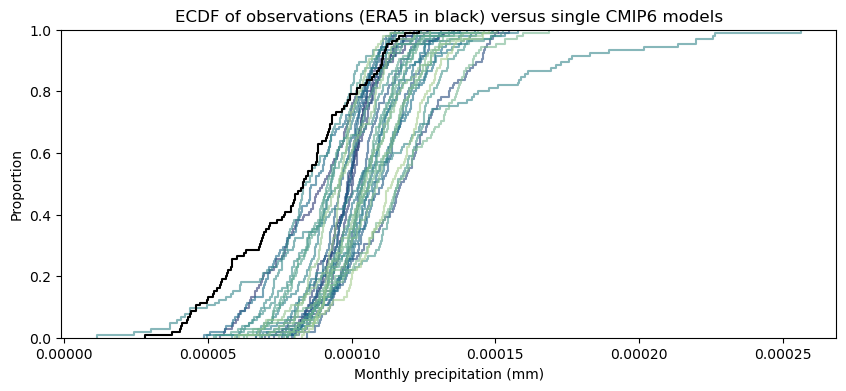

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.ecdfplot(data=his_mm_bc.pr.mean(dim = ['lat', 'lon']).to_dataframe(), x='pr', hue='model', ax=ax, alpha = 0.6, palette = "crest")
sns.ecdfplot(data = obs.tp.mean(dim = ['lat', 'lon']).to_dataframe(), x = 'tp', ax = ax, color = 'black')
ax.get_legend().set_visible(False)
ax.set_xlabel( "Monthly precipitation (mm)") 
plt.title("ECDF of observations (ERA5 in black) versus single CMIP6 models")

# 2. Only the "best"
The definition of "best" is rather complex and probably there is not a single answer. A good starting point in defining a method to find the best model in an ensemble would be the paper by [Parding et al., 2020](https://www.sciencedirect.com/science/article/pii/S2405880720300194?via%3Dihub) and the associated [web application](https://gcmeval.met.no/).

Here, we perform a Kolmogorov-Smirnov test between each historical simulation (using bias-corrected) and observations, to compare the probability distributions of monthly precipitation. 

In [33]:
ksdistance = [scipy.stats.kstest(obs.tp.mean(dim = ['lat', 'lon']), his_mm_bc.pr.mean(dim = ['lat', 'lon']).isel(model = x)).statistic for x in range(32)]

The cut-off is set to 0.3, i.e. we select only the models with a K-S distance below that value.

In [34]:
selected_models = [i for i,v in enumerate(ksdistance) if v < 0.3]

## Plotting the best distributions

Text(0.5, 1.0, 'ECDF of observations (ERA5 in black) versus single CMIP6 models')

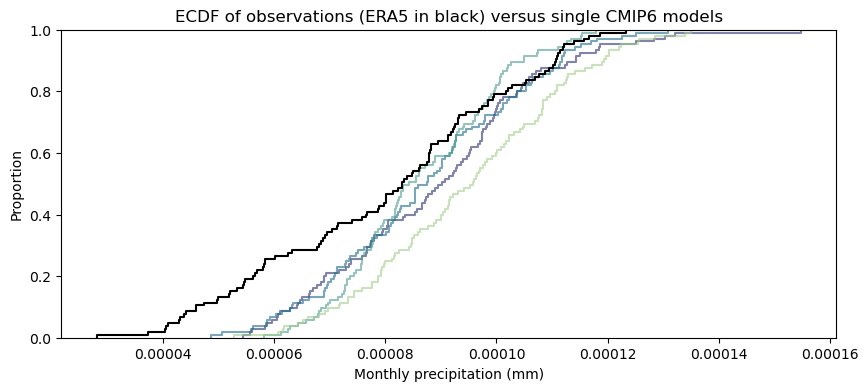

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.ecdfplot(data=his_mm_bc.pr.mean(dim = ['lat', 'lon']).isel(model = selected_models).to_dataframe(), x='pr', hue='model', ax=ax, alpha = 0.6, palette = "crest")
sns.ecdfplot(data = obs.tp.mean(dim = ['lat', 'lon']).to_dataframe(), x = 'tp', ax = ax, color = 'black')
ax.get_legend().set_visible(False)
ax.set_xlabel( "Monthly precipitation (mm)") 
plt.title("ECDF of observations (ERA5 in black) versus single CMIP6 models")

An ensemble is created using only the selected models

In [36]:
his_reduced_ensemble = his_mm_bc.isel(model = selected_models).mean(dim = 'model')
fut_reduced_ensemble = fut_mm_bc.isel(model = selected_models).mean(dim = 'model')

## 99th percentile using selected members

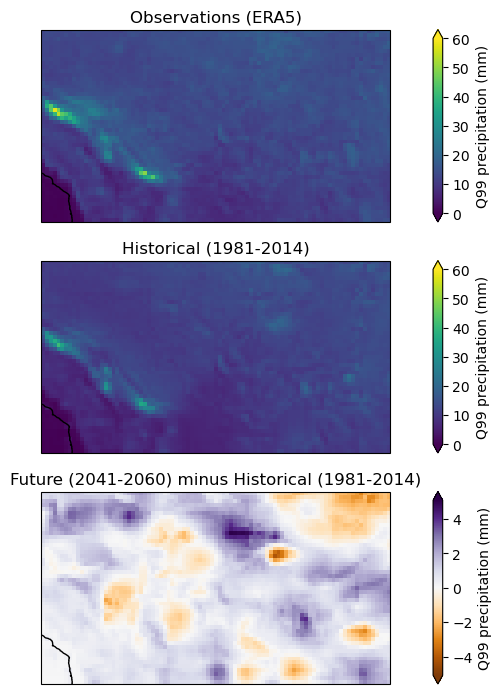

In [37]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[0].set_title('Observations (ERA5)')
axs[0].coastlines()

(his_reduced_ensemble['pr']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"})
axs[1].set_title('Historical (1981-2014)')
axs[1].coastlines()

((fut_reduced_ensemble['pr']*86400).quantile(.99, dim = 'time') - (his_reduced_ensemble['pr']*86400).quantile(.99, dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "Q99 precipitation (mm)"})
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014)')
axs[2].coastlines()


# 3. Large models: Using models with multiple members

For many models in the CMIP6 repositories there are multiple members available, some of them have more than 10 members.


This time, we filter the list of simulations keeping *all* the realisations (aka members), including `r2i1p1f1`, `r3i1p1f1` and so forth.

In [38]:
lhis = (
    list_cmip6_sims
    .query("experiment_id == 'historical'")
    .query("table_id == 'Amon'")
    .query("variable_id == 'pr'")
    .query("member_id.str.contains('i1p1f1')")
    )

Let's count the number of members for each simulation.

In [39]:
nsel_his = (lhis
        .groupby(['institution_id', 'source_id'])['member_id']
        .count()
        .reset_index()
)
nsel_his.sort_values('member_id', ascending = False).head()

,institution_id,source_id,member_id
19,EC-Earth-Consortium,EC-Earth3,72
32,MIROC,MIROC6,50
14,CSIRO,ACCESS-ESM1-5,40
29,IPSL,IPSL-CM6A-LR,32
45,NCC,NorCPM1,30


Same for future scenario

In [40]:
l585 = (
    list_cmip6_sims
    .query("experiment_id == 'ssp585'")
    .query("table_id == 'Amon'")
    .query("variable_id == 'pr'")
    .query("member_id.str.contains('i1p1f1')")
 
    )
nsel_585 = (l585
        .groupby(['institution_id', 'source_id'])['member_id']
        .count()
        .reset_index()
)

We want to select the simulations with at least 5 members in both the experiments. 

In [41]:
selected_sims_with_members_gt5 = (
    pd.merge(nsel_his, nsel_585, on = ['institution_id', 'source_id'], how = 'inner')
    .query("member_id_x > 5")
    .query("member_id_y > 5")
).reset_index()

now we create a list ...

In [42]:
list_all_sims_with_members = pd.merge(lhis, l585, on = ['institution_id', 'source_id', 'member_id'], how = 'inner')

In [43]:
selected_sims_with_members_gt5

,index,institution_id,source_id,member_id_x,member_id_y
0,8,CCCma,CanESM5,25,25
1,11,CSIRO,ACCESS-ESM1-5,40,36
2,14,EC-Earth-Consortium,EC-Earth3,72,58
3,16,EC-Earth-Consortium,EC-Earth3-Veg,8,8
4,21,IPSL,IPSL-CM6A-LR,32,6
5,23,MIROC,MIROC6,50,50
6,24,MPI-M,MPI-ESM1-2-LR,10,10


We can see that some models have a different number of realisations for the two experiments. 
For each simulation we select all the members and download them (without bias-correction)

In [44]:
data_layers = []
for i,row in selected_sims_with_members_gt5.iterrows():
    
    target_inst = row['institution_id']
    target_sour = row['source_id']
    subset_list_sim =     (
        list_all_sims_with_members
        .query("institution_id == @target_inst")
        .query("source_id == @target_sour")
    )

    single_members_data_layers = []
    for _,row in subset_list_sim.iterrows():
        mdata = model_tp.model_tp(
            this_institution_id= row['institution_id'],
            this_source_id=row['source_id'],
            this_member_id=row['member_id'],
            lat_min = lat_min, 
            lat_max = lat_max,
            lon_min = lon_min,
            lon_max = lon_max
        )
        
        mdata.add_observations(obs)        
        single_members_data_layers.append(mdata)
        
    data_layers.append(single_members_data_layers)

The idea is to combine all the members along the time dimension, to conflate the temporal information. This can be useful to create a large distribution.

Combining but each one has a different time length now

In [45]:
mm_long_his = [(lambda x : xr.concat([m.his for m in x], dim = 'time'))(x) for x in data_layers]
mm_long_fut = [(lambda x : xr.concat([m.fut for m in x], dim = 'time'))(x) for x in data_layers]

mm_long_his = [x.sel(time=x.time.dt.month.isin([1, 2, 3])) for x in mm_long_his]
mm_long_fut = [x.sel(time=x.time.dt.month.isin([1, 2, 3])) for x in mm_long_fut]

This is for example the first model

In [46]:
mm_long_his[0]

<xarray.Dataset> Size: 92MB
Dimensions:  (time: 2625, lat: 49, lon: 89)
Coordinates:
  * time     (time) datetime64[ns] 21kB 1980-01-01 1980-02-01 ... 2014-03-01
  * lon      (lon) float64 712B 288.0 288.2 288.5 288.8 ... 309.5 309.8 310.0
  * lat      (lat) float64 392B -8.0 -8.25 -8.5 -8.75 ... -19.5 -19.75 -20.0
Data variables:
    pr       (time, lat, lon) float64 92MB 5.795e-05 6.127e-05 ... 5.29e-05
Attributes: (12/56)
    CCCma_model_hash:            7e8e715f3f2ce47e1bab830db971c362ca329419
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his11
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 pr
    variant_label:               r11i1p1f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/a54e623d-646b-45ec-ab0c-a8a425e...
    version_id:                  v20190429

## Comparing distributions 
We can show the distributions of these models and compare them with observations, the smoothness is caused by the long temporal dimension

Text(0.5, 1.0, 'ECDF of observations (ERA5 in black) versus single CMIP6 models')

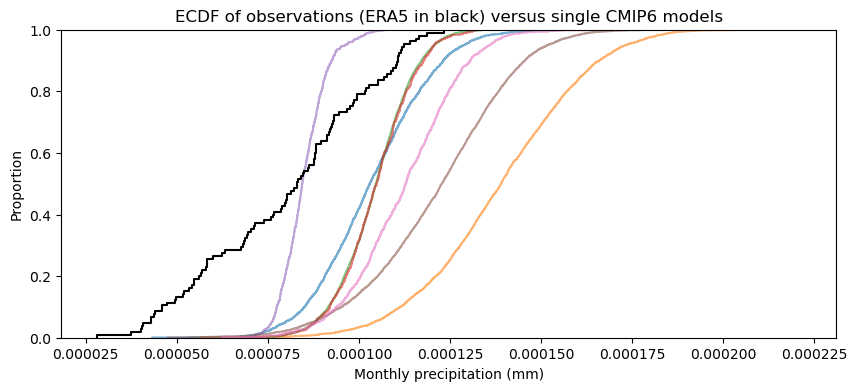

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i,_ in enumerate(mm_long_his):
    sns.ecdfplot(data=(mm_long_his[i]).pr.mean(dim = ['lat', 'lon']).to_dataframe(), x='pr', ax=ax, alpha = 0.6)
sns.ecdfplot(data = obs.tp.mean(dim = ['lat', 'lon']).to_dataframe(), x = 'tp', ax = ax, color = 'black')
ax.set_xlabel( "Monthly precipitation (mm)") 
plt.title("ECDF of observations (ERA5 in black) versus single CMIP6 models")

## Plotting the 99th percentile
Two ensembles are created extracting the 99th percentile for each model

In [48]:
his_q99_ens = xr.concat([x.quantile(.99, dim = 'time') for x in mm_long_his], dim = 'model')
fut_q99_ens = xr.concat([x.quantile(.99, dim = 'time') for x in mm_long_fut], dim = 'model')

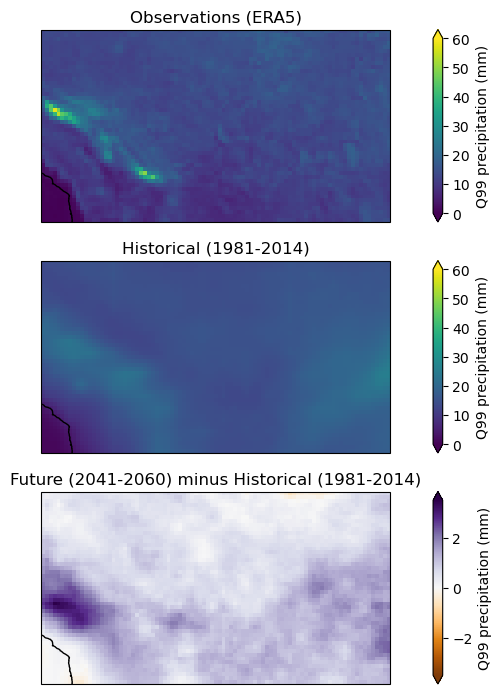

In [49]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"})
axs[0].set_title('Observations (ERA5)')
axs[0].coastlines()

(his_q99_ens['pr']*86400).mean(dim = 'model').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"})
axs[1].set_title('Historical (1981-2014)')
axs[1].coastlines()

((fut_q99_ens['pr']*86400).mean(dim = 'model') - (his_q99_ens['pr']*86400).mean(dim = 'model')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "Q99 precipitation (mm)"})
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014)')
axs[2].coastlines()



Here a composite plot showing the change in 99th percentile of precipitation for each model. 

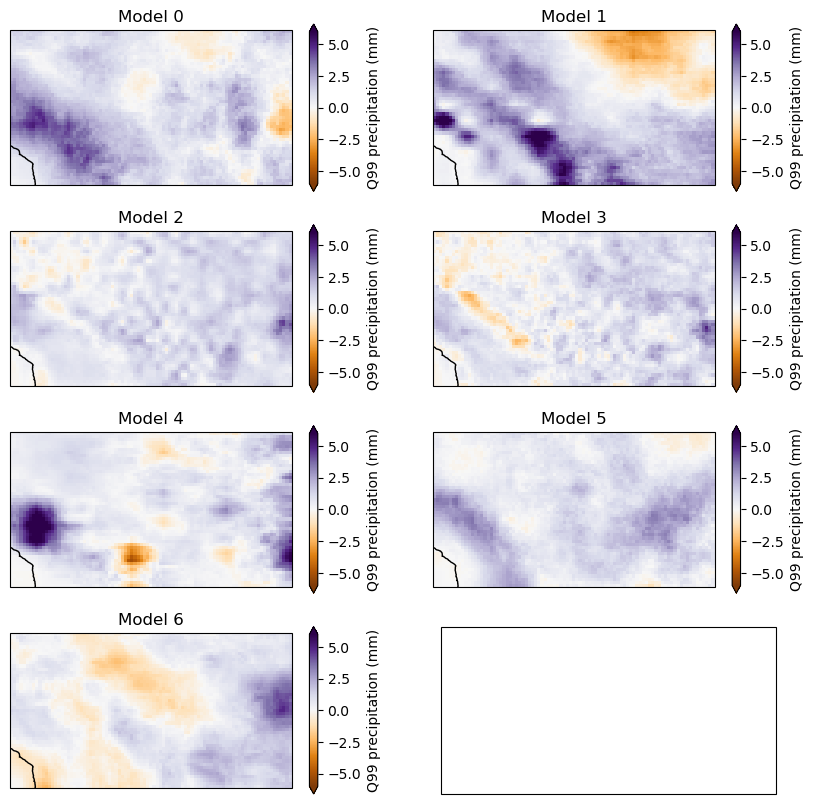

In [50]:
figs, axs = plt.subplots(ncols = 2, nrows = 4, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,10))

for i in range(4):
    for j in range(2):
        idx_model = i*2 + j
        if (idx_model < 7):
            ((fut_q99_ens['pr']*86400).isel(model = idx_model) - (his_q99_ens['pr']*86400).isel(model = idx_model)).plot(
                ax = axs[i,j], 
                transform = ccrs.PlateCarree(), cmap='PuOr',extend='both',
                vmax = 6, vmin = -6,
                cbar_kwargs={'label': "Q99 precipitation (mm)"})
            axs[i,j].set_title(f'Model {idx_model}')
            axs[i,j].coastlines()


## Creating a baseline
To understand a bit better what happens when conflating the time dimension, would be useful to create a similar ensemble but only considering the first member - i.e. without conflating.

In [51]:
mm_long_his_baseline = xr.concat([x[0].his for x in data_layers], dim = 'model')
mm_long_fut_baseline = xr.concat([x[0].fut for x in data_layers], dim = 'model')

mm_long_his_baseline = mm_long_his_baseline.sel(time=mm_long_his_baseline.time.dt.month.isin([1, 2, 3]))
mm_long_fut_baseline = mm_long_fut_baseline.sel(time=mm_long_fut_baseline.time.dt.month.isin([1, 2, 3]))

his_baseline_bc = mm_long_his_baseline.mean(dim = 'model')*86400
fut_baseline_bc = mm_long_fut_baseline.mean(dim = 'model')*86400

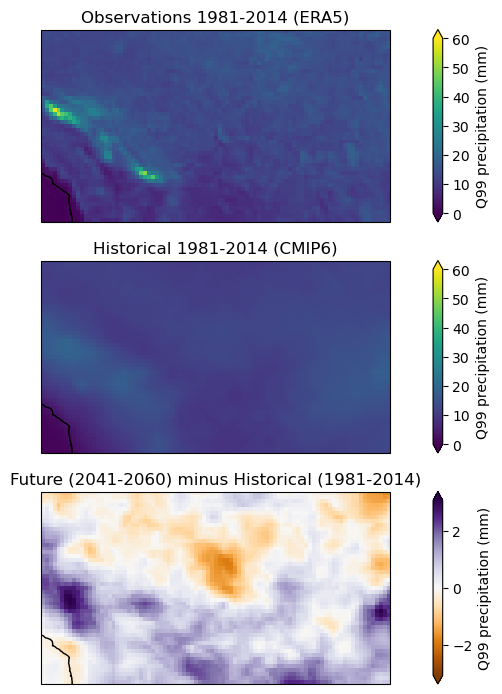

In [52]:
figs, axs = plt.subplots(ncols = 1, nrows = 3, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
(obs['tp']*86400).quantile(.99, dim = 'time').plot(
    ax = axs[0], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
    )
axs[0].set_title('Observations 1981-2014 (ERA5)')
axs[0].coastlines()

(his_baseline_bc['pr']).quantile(.99, dim = 'time').plot(
    ax = axs[1], transform = ccrs.PlateCarree(),
    cmap='viridis',extend='both', vmax = 60, vmin = 0,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[1].set_title('Historical 1981-2014 (CMIP6)')
axs[1].coastlines()

((fut_baseline_bc['pr']).quantile(.99, dim = 'time') - (his_baseline_bc['pr']).quantile(.99, dim = 'time')).plot(
    ax = axs[2], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[2].set_title('Future (2041-2060) minus Historical (1981-2014)')
axs[2].coastlines()


# Conclusions
In t

Text(0.5, 0.98, '99th percentile of precipitation for winter months\nFuture (2041-2060) minus Historical (1981-2014)')

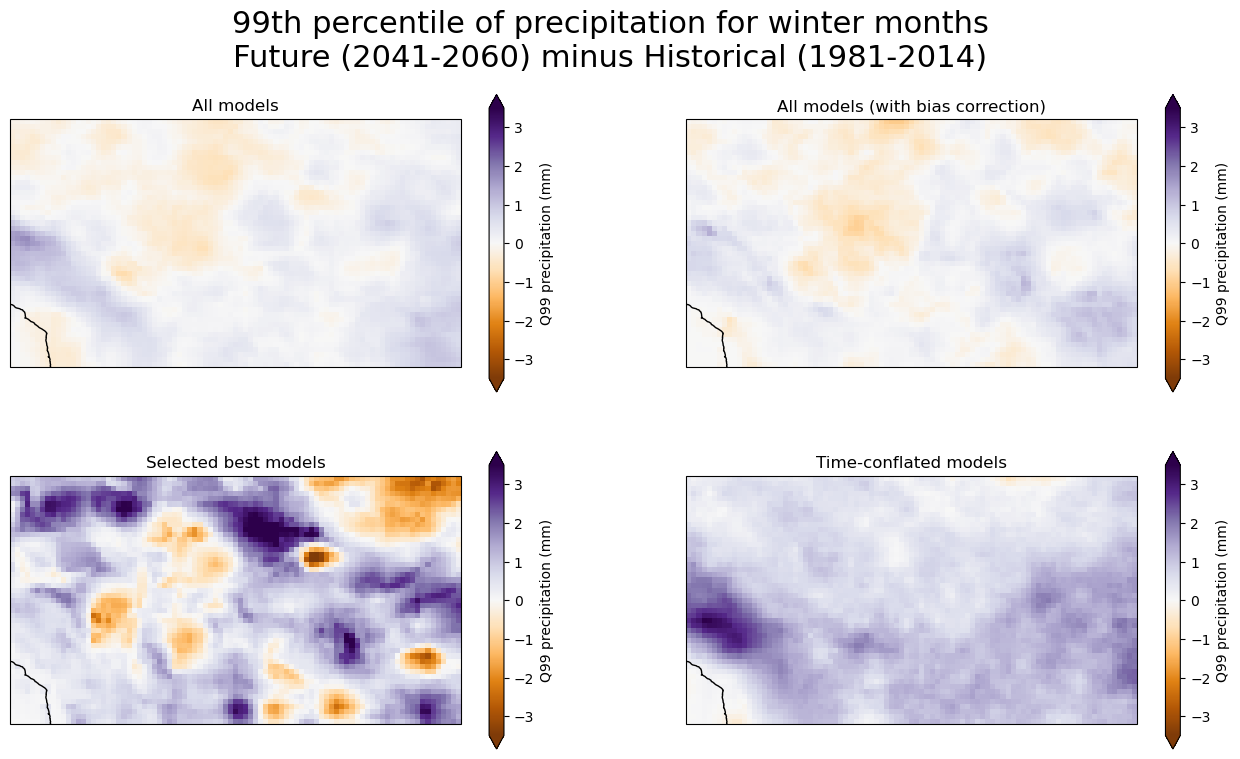

In [77]:
figs, axs = plt.subplots(ncols = 2, nrows = 2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8.5))

((fut_ensemble['pr']).quantile(.99, dim = 'time') - (his_ensemble['pr']).quantile(.99, dim = 'time')).plot(
    ax = axs[0,0], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both', vmax = 3.5, vmin = -3.5,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[0,0].set_title('All models')
axs[0,0].coastlines()

((fut_ensemble_bc['pr']).quantile(.99, dim = 'time') - (his_ensemble_bc['pr']).quantile(.99, dim = 'time')).plot(
    ax = axs[0,1], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',vmax = 3.5, vmin = -3.5,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[0,1].set_title('All models (with bias correction)')
axs[0,1].coastlines()

((fut_reduced_ensemble['pr']*86400).quantile(.99, dim = 'time') - (his_reduced_ensemble['pr']*86400).quantile(.99, dim = 'time')).plot(
    ax = axs[1,0], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',vmax = 3.5, vmin = -3.5,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[1,0].set_title('Selected best models')
axs[1,0].coastlines()

((fut_q99_ens['pr']*86400).mean(dim = 'model') - (his_q99_ens['pr']*86400).mean(dim = 'model')).plot(
    ax = axs[1,1], transform = ccrs.PlateCarree(),
    cmap='PuOr',extend='both',vmax = 3.5, vmin = -3.5,
    cbar_kwargs={'label': "Q99 precipitation (mm)"}
)
axs[1,1].set_title('Time-conflated models')
axs[1,1].coastlines()

figs.suptitle("99th percentile of precipitation for winter months\nFuture (2041-2060) minus Historical (1981-2014)", fontsize = 22)